In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path


In [2]:
import os
os.chdir('../..')
print("Working directory:", os.getcwd())

Working directory: c:\0. Studia\Magisterka\Praca magisterska\Experiments


In [3]:
json_path = Path("results/Predictions/FakeRealMusicOriginal/FULL_TEST/full_track/predictions.json")
# json_path = Path("results/FakeRealMusicOriginal/500_samples/explanations.json")

In [ ]:
with open(json_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

rows = []
for source, items in raw.items():
    for idx, rec in items.items():
        pred = rec.get("preedictions", {})
        comp = rec.get("component_influences", {})
        rows.append({
            "source": source,
            "id": idx,
            "file_path": pred.get("file_path"),
            "score_fake_prob": pred.get("model_prediction"),
            "predicted_class": pred.get("predicted_class"),
            **{f"ci_{k}": v for k, v in comp.items()}
        })

df = pd.DataFrame(rows).sort_values(["source","id"]).reset_index(drop=True)

threshold = 0.5
df["pred_label_by_threshold"] = (df["score_fake_prob"] >= threshold).map({True:"Fake", False:"Real"})
df["is_correct_vs_threshold"] = (df["pred_label_by_threshold"] == df["predicted_class"])

comp_cols = [c for c in df.columns if c.startswith("ci_")]
df_long = df.melt(id_vars=["source","id","file_path","score_fake_prob","predicted_class"],
                  value_vars=comp_cols, var_name="component", value_name="influence")

### Distribution plots per source

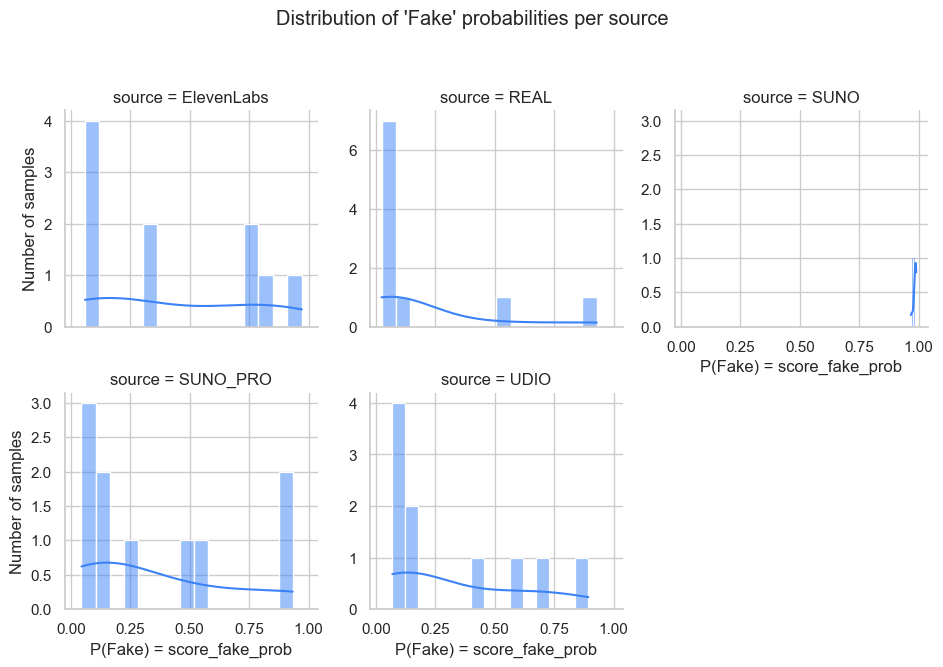

In [ ]:
sns.set(style="whitegrid")
g = sns.FacetGrid(df, col="source", col_wrap=3, sharex=True, sharey=False, height=3.2)
g.map(sns.histplot, "score_fake_prob", bins=15, kde=True, color="#3b82f6")
g.set_axis_labels("P(Fake) = score_fake_prob", "Number of samples")
g.fig.suptitle("Distribution of 'Fake' probabilities per source", y=1.04)
plt.tight_layout()
plt.show()


### Scatter: score vs source with threshold and class colour i kolorem klasy

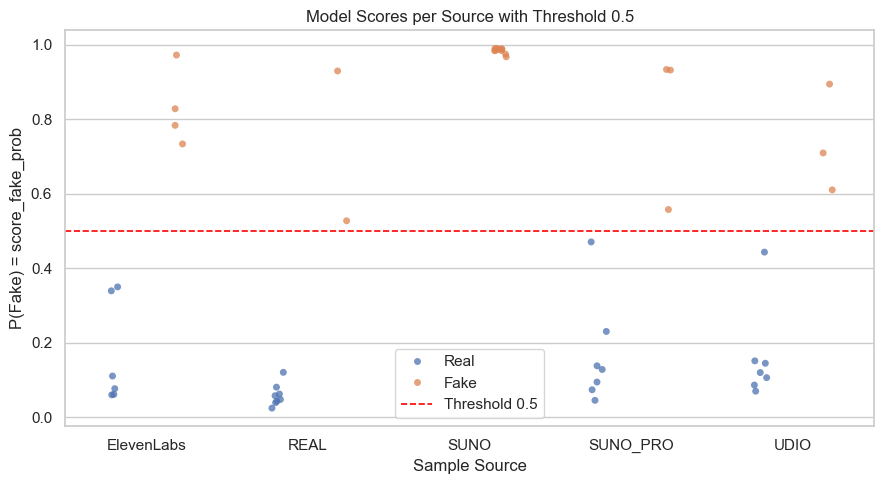

In [8]:
plt.figure(figsize=(9,5))
ax = sns.stripplot(
    data=df,
    x="source",
    y="score_fake_prob",
    hue="predicted_class",
    dodge=True,
    alpha=0.75
)
plt.axhline(0.5, color="red", linestyle="--", linewidth=1.2, label="Threshold 0.5")
plt.ylabel("P(Fake) = score_fake_prob")
plt.xlabel("Sample Source")
plt.title("Model Scores per Source with Threshold 0.5")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


### Percentile i IQR per source

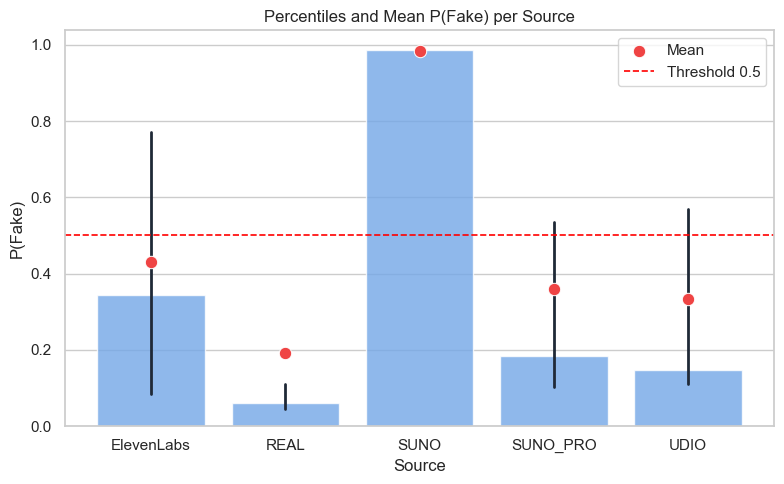

In [10]:
import json, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

rows=[]
for source, items in data.items():
    for k, rec in items.items():
        pred = rec.get("preedictions", {})
        rows.append({
            "source": source,
            "score_fake_prob": pred.get("model_prediction"),
            "predicted_class": pred.get("predicted_class"),
        })
df = pd.DataFrame(rows)

agg = df.groupby("source").agg(
    p25=("score_fake_prob", lambda s: s.quantile(0.25)),
    median=("score_fake_prob", "median"),
    p75=("score_fake_prob", lambda s: s.quantile(0.75)),
    mean=("score_fake_prob", "mean")
).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=agg, x="source", y="median", color="#60a5fa", alpha=0.8)
for i, r in agg.iterrows():
    plt.plot([i, i], [r["p25"], r["p75"]], color="#1f2937", linewidth=2)
sns.scatterplot(data=agg, x="source", y="mean", color="#ef4444", s=80, zorder=3, label="Mean")
plt.axhline(0.5, color="red", linestyle="--", linewidth=1.2, label="Threshold 0.5")
plt.ylabel("P(Fake)")
plt.xlabel("Source")
plt.title("Percentiles and Mean P(Fake) per Source")
plt.legend()
plt.tight_layout()
plt.show()


### Proportion of “Fake” decisions at different thresholds
The curves show what percentage of samples (per source) would be considered “Fake” when changing the threshold from 0 to 1. This provides insight into the sensitivity of the decision to the threshold.

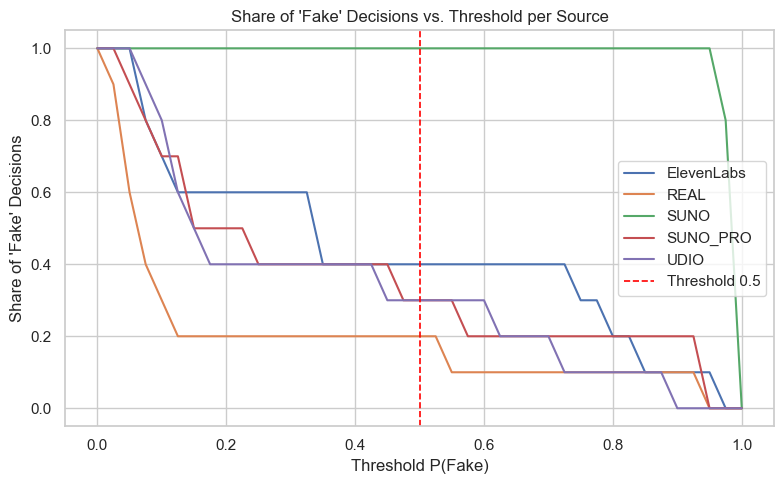

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

thresholds = np.linspace(0.0, 1.0, 41)
shares = []
for thr in thresholds:
    share = (df.assign(pred_thr=(df["score_fake_prob"]>=thr))
               .groupby("source")["pred_thr"].mean()
               .rename("share_fake")
               .reset_index())
    share["threshold"] = thr
    shares.append(share)
curve = pd.concat(shares, ignore_index=True)

plt.figure(figsize=(8,5))
sns.lineplot(data=curve, x="threshold", y="share_fake", hue="source")
plt.axvline(0.5, color="red", linestyle="--", linewidth=1.2, label="Threshold 0.5")
plt.xlabel("Threshold P(Fake)")
plt.ylabel("Share of 'Fake' Decisions")
plt.title("Share of 'Fake' Decisions vs. Threshold per Source")
plt.legend()
plt.tight_layout()
plt.show()


### Decision confidence shares
Focuses on prediction confidence: very real (P<0.2), uncertain (0.2–0.8), very fake (P≥0.8). Shows how often the model is “decisive” in each source group.

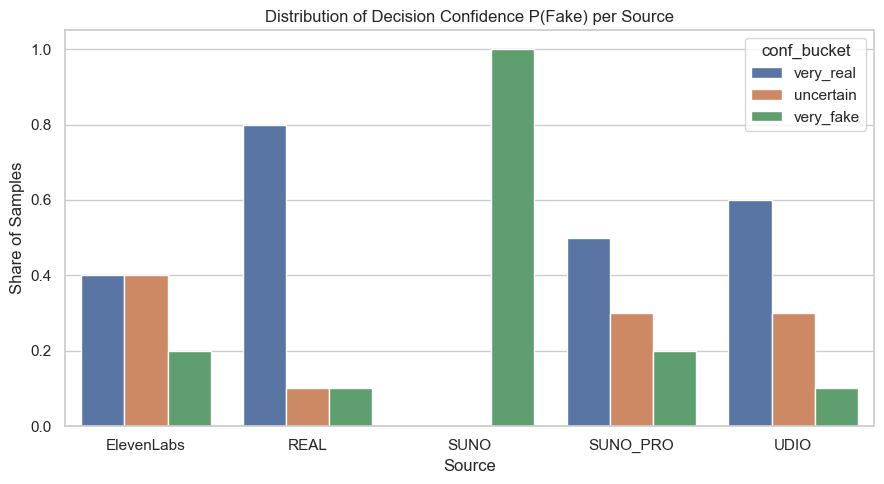

In [12]:
bins = [0.0, 0.2, 0.8, 1.0]
labels = ["very_real","uncertain","very_fake"]
conf_df = df.assign(conf_bucket=pd.cut(df["score_fake_prob"], bins=bins, labels=labels, include_lowest=True))
conf_share = (conf_df.groupby("source")["conf_bucket"]
                     .value_counts(normalize=True)
                     .rename("share")
                     .reset_index())

plt.figure(figsize=(9,5))
sns.barplot(data=conf_share, x="source", y="share", hue="conf_bucket")
plt.ylabel("Share of Samples")
plt.xlabel("Source")
plt.title("Distribution of Decision Confidence P(Fake) per Source")
plt.tight_layout()
plt.show()
